# Interactive Notebook for FMD KPIs

## Setup

In [14]:
# workhorse modules
import pandas as pd
from datetime import timedelta, datetime
from pathlib import Path
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual

# local utility functions
from utils.general_utils import (
    add_fiscal_year,
    compute_is_on_time,
    set_pd_params,
    compute_pm_cm,
    compute_pm_cm_by_month,
    compute_kpi_table,
    compute_kpi_table_by_month,
)
from utils.vis_utils import set_plot_params, pointplot_with_barplot

In [60]:
set_pd_params()
set_plot_params(12, 6)

In [61]:
scorecard_path = Path.cwd() / "data" / "scorecard_data.pkl"
wr_tidy = pd.read_pickle(scorecard_path)

In [70]:
# drop rows that were canceled
cond_valid = ~wr_tidy["status"].isin(["Can", "Rej", "R"])

wr_valid = wr_tidy[cond_valid]

print(
    f"By dropping canceled and rejected work orders, we have removed {len(wr_tidy) - len(wr_valid):,} rows."
)

By dropping canceled and rejected work orders, we have removed 4,029 rows.


## Decide on what basis to assign fiscal year

In [71]:
# add 'fiscal_year' column based on date_closed
wr_fy = interactive(
    add_fiscal_year,
    assign_fy_on=["request", "completion", "closure"],
    df=fixed(wr_valid),
)
wr_fy

interactive(children=(Dropdown(description='assign_fy_on', index=2, options=('request', 'completion', 'closure…

In [82]:
result = wr_fy.result

In [83]:
wr_pm = result.copy()

# this defines which problem types are considered PMs
pm_list = [
    "BUILDING INTERIOR INSPECTION",
    "BUILDING PM",
    "HVAC|PM",
    "INSPECTION",
    "PREVENTIVE MAINT",
]

# filter data to PM types only
cond_pm = wr_pm["problem_type"].isin(pm_list)

# apply filter conditions
wr_pm = wr_pm[cond_pm]

# the benchmark for all PMs is 21 days
wr_pm["benchmark"] = 21

print(f"The filtered PMs dataframe has {wr_pm.shape[0]:,} rows.")

The filtered PMs dataframe has 9,595 rows.


In [84]:
# add "is_on_time" column with performance data
wr_pm = wr_pm.dropna(subset=["days_to_completion", "benchmark"])
pms_on_time = wr_pm.apply(compute_is_on_time, axis=1)

In [85]:
pm_compliance = compute_kpi_table(
    pms_on_time, "percent_PMs_on_time", "total_PMs", grouping_var="fiscal_year"
)
pm_compliance

,percent_PMs_on_time,total_PMs
fiscal_year,,
2015,35.87,92
2016,77.46,954
2017,54.82,1432
2018,75.47,2087
2019,51.04,1585
2020,36.45,1402
2021,41.84,674


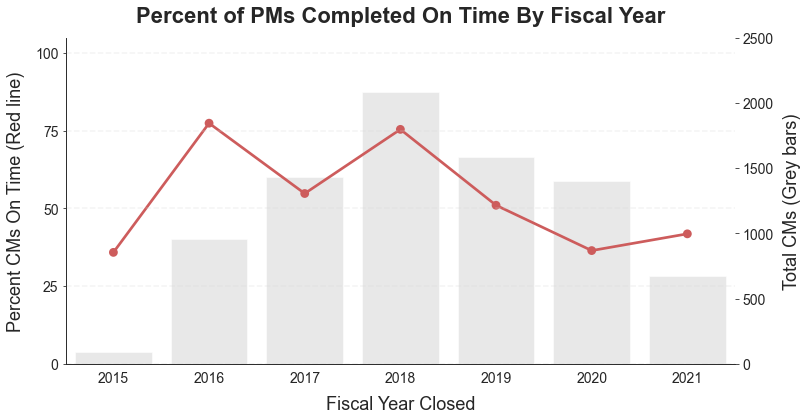

In [86]:
pointplot_with_barplot(
    pm_compliance,
    x=pm_compliance.index,
    point_y="percent_PMs_on_time",
    bar_y="total_PMs",
    ymax_bar=2_500,
    xlabel="Fiscal Year Closed",
    ylabel_point="Percent CMs On Time (Red line)",
    ylabel_bar="Total CMs (Grey bars)",
    title="Percent of PMs Completed On Time By Fiscal Year",
)